In [1]:
import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()
sns.set()
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import calibration_curve

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)


COUNTRY2 = 'full_merged_dumvar'
TRAIN_PATH2, TEST_PATH2 = get_data_filepaths(COUNTRY2)

COUNTRY = 'full_merged'
TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

In [2]:
#Logistic Regression
# Load and transform the training data
X_train_log, y_train_log, w_train_log = load_data(TRAIN_PATH2)
# Load and transform the test set
X_test_log, y_test_log, w_test_log = load_data(TEST_PATH2)


#XGBoost
# Load and transform the training data
X_train_xgb, y_train_xgb, w_train_xgb = split_features_labels_weights(TRAIN_PATH)
X_train_xgb = X_train_xgb.to_numpy()
w_train_xgb = w_train_xgb.to_numpy().reshape(-1)
# Load the test set
X_test_xgb, y_test_xgb, w_test_xgb = split_features_labels_weights(TEST_PATH)
X_test_xgb = X_test_xgb.to_numpy()
w_test_xgb = w_test_xgb.to_numpy().reshape(-1)


#Random Forest
# Load and transform the training data
X_train_rf, y_train_rf, w_train_rf = split_features_labels_weights(TRAIN_PATH)
X_train_rf['age'].fillna(2.0, inplace=True)
y_train_rf = np.ravel(y_train_rf)
w_train_rf = np.ravel(w_train_rf)
# Load the test set
X_test_rf, y_test_rf, w_test_rf = split_features_labels_weights(TEST_PATH)
X_test_rf['age'].fillna(2.0, inplace=True)
y_test_rf = np.ravel(y_test_rf)
w_test_rf = np.ravel(w_test_rf)

In [3]:
logit = LogisticRegression(C=0.002364489412645407, max_iter=3000, penalty='l1',
                   random_state=8, solver='liblinear')

rf = RandomForestClassifier(class_weight={0: 0.6, 1: 0.4}, max_depth=15,
                       max_features='log2', min_samples_split=130,
                       n_estimators=125, random_state=1000)

xgb = xgb.XGBClassifier(tree_method="hist", objective='binary:logistic',
                        base_score=None, booster='gbtree', callbacks=None,
                        colsample_bylevel=None, colsample_bynode=None,
                        colsample_bytree=None, early_stopping_rounds=None,
                        enable_categorical=True, eval_metric='logloss',
                        feature_types=None, gamma=100, gpu_id=None, grow_policy=None,
                        importance_type=None, interaction_constraints=None,
                        learning_rate=0.2, max_bin=None, max_cat_threshold=None,
                        max_cat_to_onehot=1, max_delta_step=5, max_depth=None,
                        max_leaves=None, min_child_weight=None,
                        monotone_constraints=None, n_estimators=25, n_jobs=None,
                        num_parallel_tree=None, predictor=None, random_state=None)

In [4]:
clf_dict = {
    'Logistic Regression': logit,
    'Random Forest': rf,
    'XG Boost': xgb  
}

### Predicted Probabilities
Binary classification algorithms may return a matrix of predicted probabilities for class 0 and class 1 in that order. The interest is in class 1, or "success".

In [5]:
# Empty lists to be filled with the predicted probabilities
logit_prob = []
rf_prob = []
xgb_prob = []

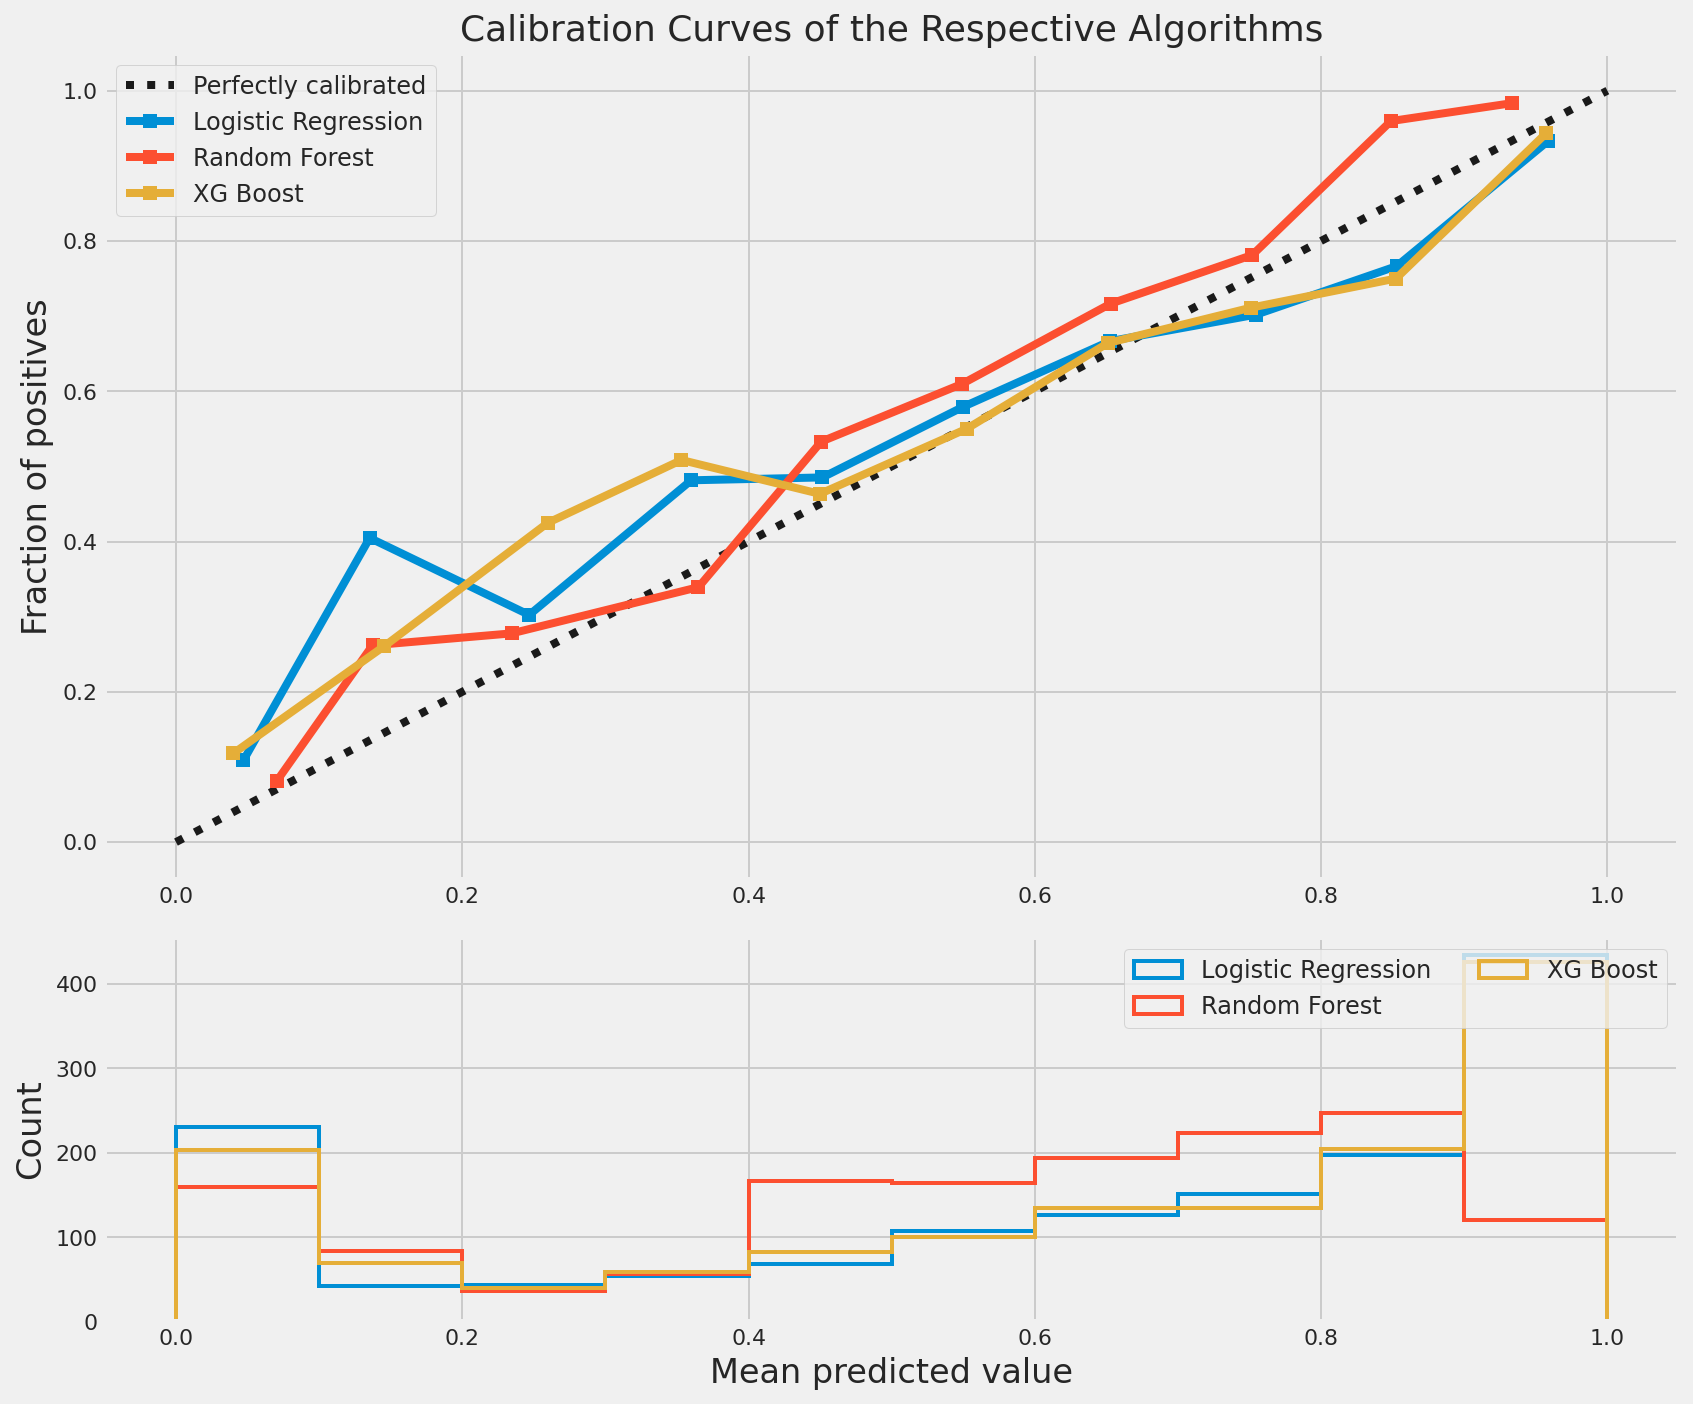

In [6]:
# Generate predicted probabilities, which feed into individual lists and...
# are used to plot the calibration curves
plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for key, clf in clf_dict.items():
    
    if key == 'Logistic Regression':
        clf.fit(X_train_log, y_train_log, sample_weight=w_train_log)
        y_train_predict_proba_log = clf.predict_proba(X_train_log)[:, 1]
        y_test_predict_proba_log = clf.predict_proba(X_test_log)[:, 1]
        logit_prob = np.append(y_train_predict_proba_log, y_test_predict_proba_log)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test_log, y_test_predict_proba_log, 
                                                                        n_bins=10)
        ax2.hist(y_test_predict_proba_log, range=(0, 1), bins=10, label=key, histtype="step", lw=2)
    elif key == 'Random Forest':
        clf.fit(X_train_rf, y_train_rf, sample_weight=w_train_rf)
        y_train_predict_proba_rf = clf.predict_proba(X_train_rf)[:, 1]
        y_test_predict_proba_rf = clf.predict_proba(X_test_rf)[:, 1]
        rf_prob = np.append(y_train_predict_proba_rf, y_test_predict_proba_rf)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test_rf, y_test_predict_proba_rf, 
                                                                        n_bins=10)
        ax2.hist(y_test_predict_proba_rf, range=(0, 1), bins=10, label=key, histtype="step", lw=2)
    else:
        clf.fit(X_train_xgb, y_train_xgb, sample_weight=w_train_xgb)
        y_train_predict_proba_xgb = clf.predict_proba(X_train_xgb)[:, 1]
        y_test_predict_proba_xgb = clf.predict_proba(X_test_xgb)[:, 1]
        xgb_prob = np.append(y_train_predict_proba_xgb, y_test_predict_proba_xgb)
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test_xgb, y_test_predict_proba_xgb, 
                                                                        n_bins=10)
        ax2.hist(y_test_predict_proba_xgb, range=(0, 1), bins=10, label=key, histtype="step", lw=2)
        
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (key, ))


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left", fontsize=12)
ax1.set_title('Calibration Curves of the Respective Algorithms', fontsize=18)

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper right", ncol=2, fontsize=12)

plt.tight_layout()
plt.show()

### Comparative Probability Distributions

In [7]:
pred_probabilities = pd.DataFrame(
                                {'Logistic Regression': logit_prob,
                                'Random Forest': rf_prob,
                                'XG Boost': xgb_prob
                                })

In [8]:
# Predicted probabilities DataFrame from uncalibrated training set
pred_probabilities

,Logistic Regression,Random Forest,XG Boost
0,0.992463,0.881767,0.986039
1,0.019029,0.031800,0.007466
2,0.979952,0.834699,0.967678
3,0.968340,0.837294,0.939997
4,0.662808,0.534284,0.608953
...,...,...,...
5801,0.928348,0.750243,0.920604
5802,0.601530,0.395138,0.737752
5803,0.360158,0.417607,0.433642
5804,0.994272,0.955796,0.992229


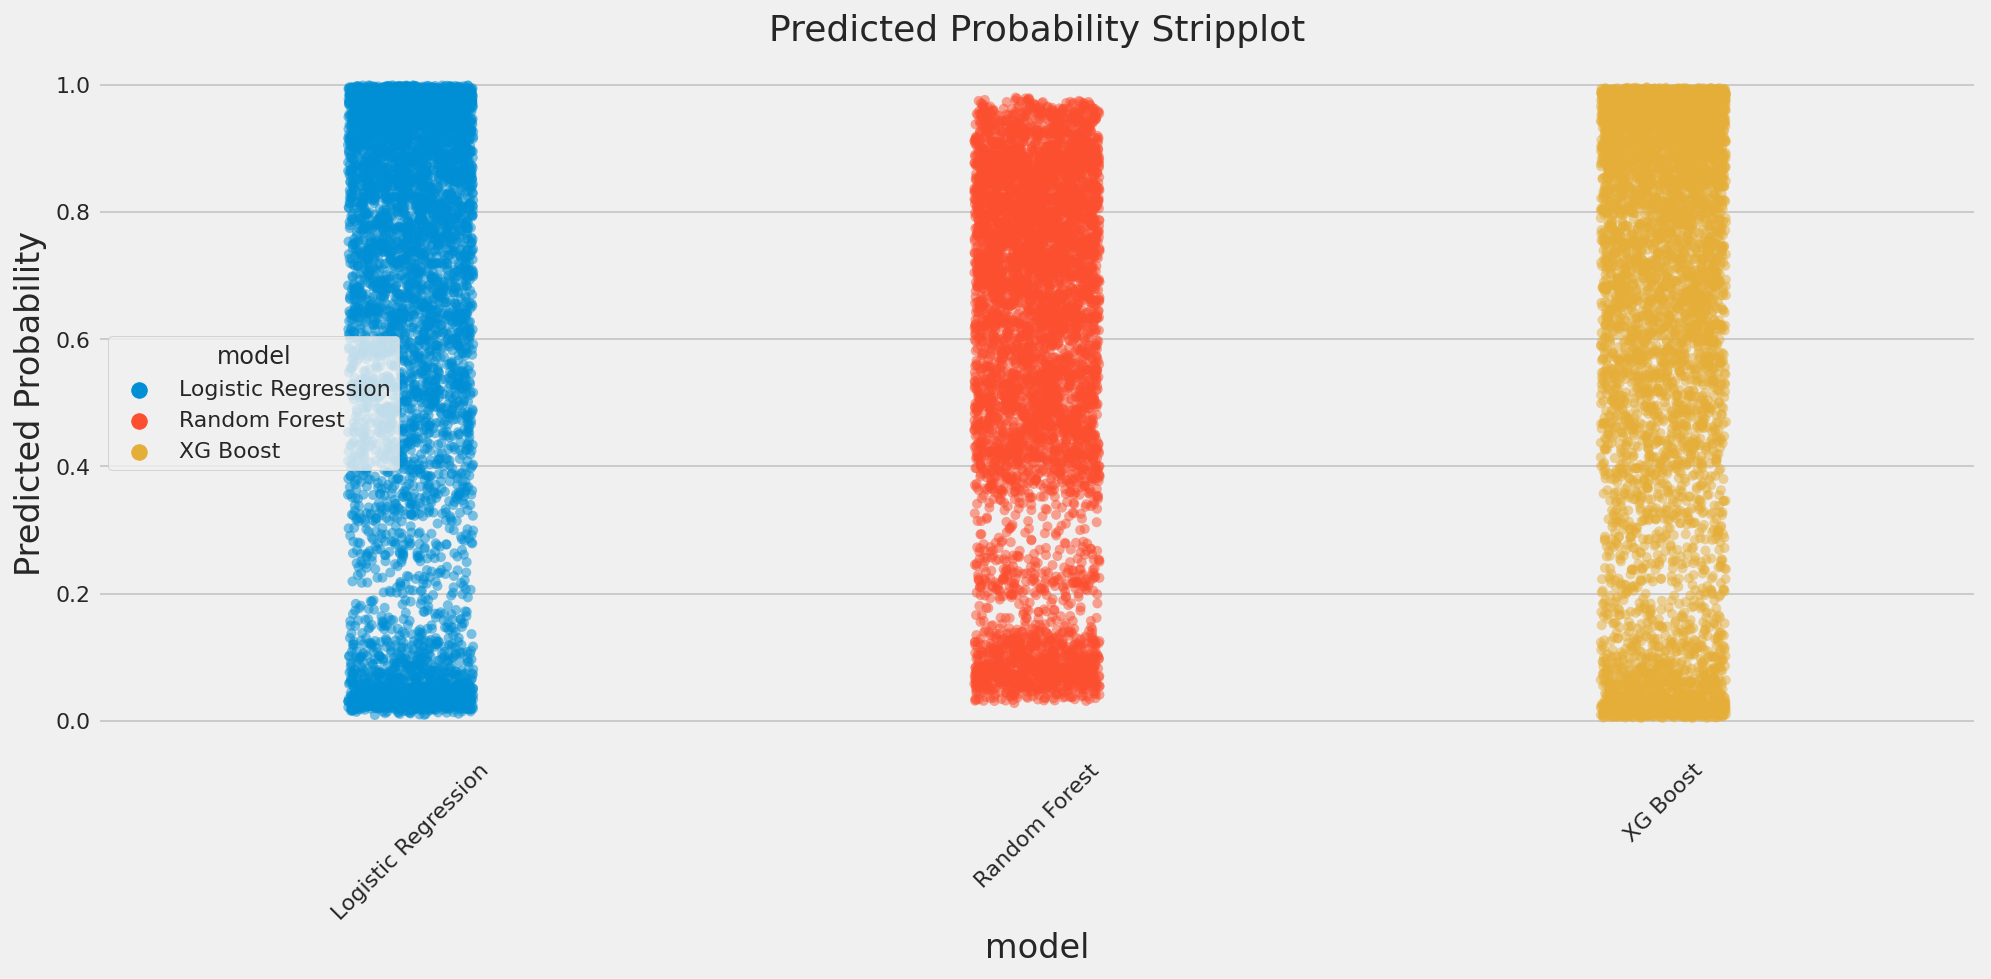

In [9]:
# Certain clusters of neighbourhoods do share similar distributions of 'SalePrice' and/or 'PriceSF'
fig, ax = plt.subplots(figsize=(15,6))

df_melt = pd.melt(pred_probabilities, var_name='model', value_name='probabilities')
sns.stripplot(x='model', y='probabilities', data=df_melt, hue='model', jitter=0.1, alpha=0.5, ax=ax)

ax.set_ylabel("Predicted Probability")
#ax.legend(loc="upper right", fontsize=11)
ax.set_ylim([-0.05, 1.05])
plt.title('Predicted Probability Stripplot', fontsize=18)
plt.xticks(rotation=45)
plt.show()

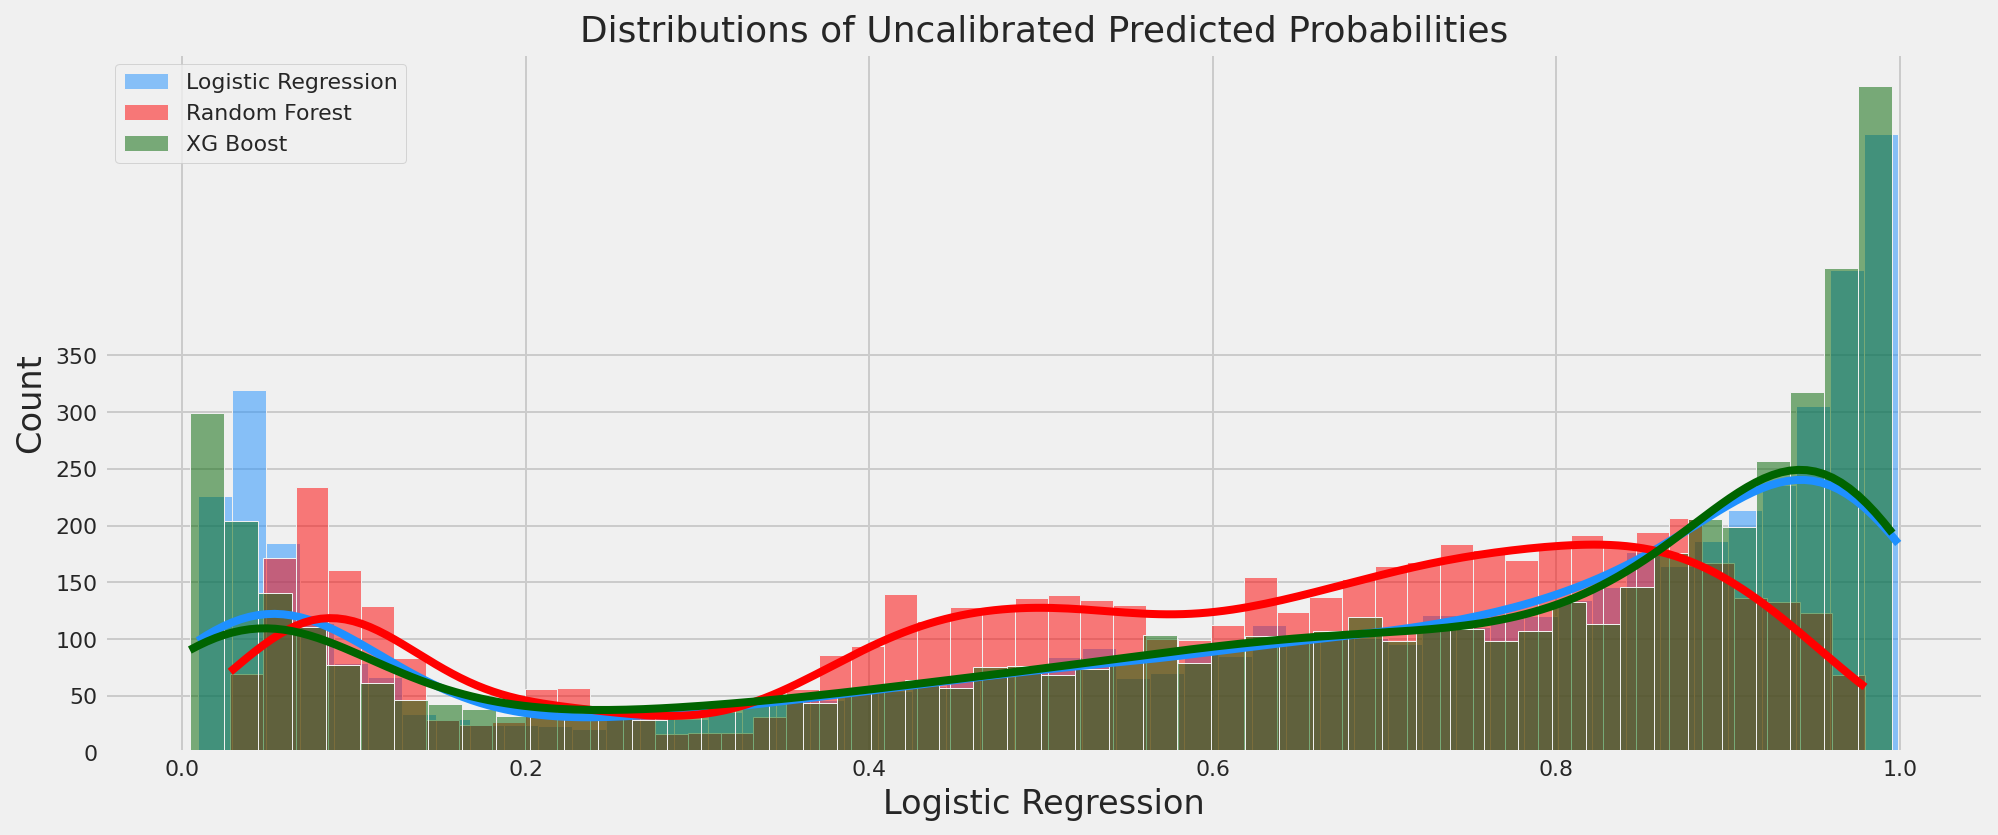

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(pred_probabilities['Logistic Regression'], bins=50, kde=True, ax=ax, color='dodgerblue', 
             label='Logistic Regression')
sns.histplot(pred_probabilities['Random Forest'], bins=50, kde=True, ax=ax, color='red', 
             label='Random Forest')
sns.histplot(pred_probabilities['XG Boost'], bins=50, kde=True, ax=ax, color='darkgreen', 
             label='XG Boost')

ax.yaxis.set_ticks(np.arange(0.00, 400, 50))
ax.legend(loc="center", fontsize=12)
plt.title('Distributions of Uncalibrated Predicted Probabilities', fontsize=18)
plt.legend();

In [11]:
f1_scorer = make_scorer(f1_score)

In [12]:
# Must use stratified kFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3)

In [13]:
logit.fit(X_train_log, y_train_log)
y_hat_train_lr = logit.predict(X_train_log)
y_hat_test_lr = logit.predict(X_test_log)
scores_lr = cross_val_score(logit, X_train_log, y_train_log, scoring=f1_scorer, cv=kf)

print("Logit CV F1 scores:", scores_lr)
print("Logit mean CV score:", np.mean(scores_lr))

Logit CV F1 scores: [0.85100287 0.85098227 0.85145631]
Logit mean CV score: 0.8511471490706026


In [14]:
rf.fit(X_train_rf, y_train_rf)
y_hat_train_rf = rf.predict(X_train_rf)
y_hat_test_rf = rf.predict(X_test_rf)
scores_rf = cross_val_score(rf, X_train_rf, y_train_rf, scoring=f1_scorer, cv=kf)

print("RF CV F1 scores:", scores_rf)
print("RF mean CV score:", np.mean(scores_rf))

RF CV F1 scores: [0.83081897 0.83214872 0.83061889]
RF mean CV score: 0.8311955243900909


In [15]:
xgb.fit(X_train_xgb, y_train_xgb)
y_hat_train_xgb = xgb.predict(X_train_xgb)
y_hat_test_xgb = xgb.predict(X_test_xgb)
scores_xgb = cross_val_score(xgb, X_train_xgb, y_train_xgb, scoring=f1_scorer, cv=kf)

print("XGB CV F1 scores:", scores_xgb)
print("XGB mean CV score:", np.mean(scores_xgb))

XGB CV F1 scores: [0.85100287 0.85098227 0.85145631]
XGB mean CV score: 0.8511471490706026
